<a href="https://colab.research.google.com/github/huzaifa003/requirements-fine-tune/blob/main/Requirements_fine_tune_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,3.993800
20,4.325200
30,4.075300
40,4.243800
50,4.091900
60,4.049400
70,4.027400
80,3.786000
90,3.721900
100,3.811500


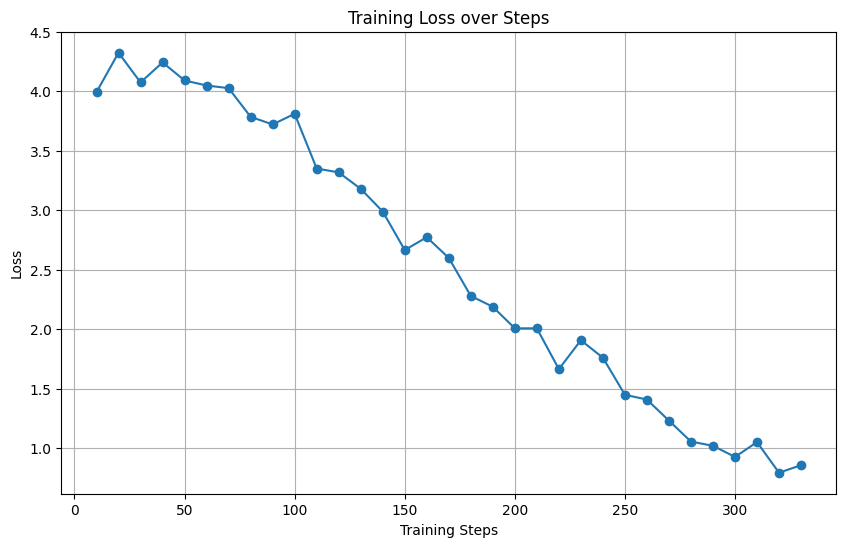


BLEU Score Evaluation on Test Examples:


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset

# -------------------------------------------------
# Visualization Functions
# -------------------------------------------------
def plot_data_distribution(df):
    """Plot the distribution of requirement types in the DataFrame."""
    counts = df['requirement_type'].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.xlabel('Requirement Type')
    plt.ylabel('Count')
    plt.title('Distribution of Requirement Types')
    plt.grid(True)
    plt.show()

def plot_training_loss(trainer):
    """Plot the training loss over steps using the trainer's log history."""
    log_history = trainer.state.log_history
    loss_logs = [entry for entry in log_history if 'loss' in entry]
    if not loss_logs:
        print("No loss logs found. Ensure you have logging enabled.")
        return
    steps = [entry['step'] for entry in loss_logs]
    losses = [entry['loss'] for entry in loss_logs]
    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, marker='o')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss over Steps')
    plt.grid(True)
    plt.show()

# -------------------------------------------------
# Load and Split Dataset
# -------------------------------------------------
# Load the dataset from the JSONL file
dataset_all = load_dataset("json", data_files="sampled_requirements.jsonl")["train"]
# Split into train and test (e.g., 90% train, 10% test)
split_dataset = dataset_all.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# -------------------------------------------------
# Fine-Tuning T5-small Example
# -------------------------------------------------
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

def preprocess_function(example):
    # For fine-tuning, use "prompt" as input and "completion" as target.
    input_text = example["prompt"]
    target_text = example["completion"]
    inputs = tokenizer(input_text, truncation=True, max_length=512)
    targets = tokenizer(target_text, truncation=True, max_length=128)
    inputs["labels"] = targets["input_ids"]
    return inputs

# Process the training dataset
tokenized_train_dataset = train_dataset.map(
    preprocess_function, batched=True, remove_columns=train_dataset.column_names
)

training_args = TrainingArguments(
    output_dir="./t5_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
)

# Use DataCollatorForSeq2Seq to pad sequences dynamically
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    data_collator=data_collator,
)

trainer.train()

# Visualize training loss after training
plot_training_loss(trainer)

# -------------------------------------------------
# BLEU Score Evaluation on Test Examples
# -------------------------------------------------
def compute_bleu_score(model, tokenizer, prompt, reference, max_length=128):
    """
    Generate a completion for a given prompt using the model,
    then compute the BLEU score comparing the generated output
    to the reference text.
    """
    # Prepare the input
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate output
    output_ids = model.generate(**inputs, max_length=max_length)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Tokenize using nltk.word_tokenize for better tokenization
    hypothesis = nltk.word_tokenize(generated_text)
    reference_tokens = [nltk.word_tokenize(reference)]

    bleu = sentence_bleu(reference_tokens, hypothesis)
    return bleu, generated_text

# Take a couple of examples from the test dataset for evaluation
print("\nBLEU Score Evaluation on Test Examples:")
# Here we take the first 2 examples from the test split
for idx, ex in enumerate(test_dataset.select(range(2))):
    bleu, generated = compute_bleu_score(model, tokenizer, ex["prompt"], ex["completion"])
    print(f"Example {idx+1}:")
    print("Prompt:             ", ex["prompt"])
    print("Reference Completion:", ex["completion"])
    print("Generated Completion:", generated)
    print("BLEU Score:          ", bleu)
    print("-" * 50)


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def compute_bleu_score(model, tokenizer, prompt, reference, max_length=128):
    """
    Generate a completion for a given prompt using the model,
    then compute the BLEU score comparing the generated output
    to the reference text.
    """
    # Prepare the input
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate output
    output_ids = model.generate(**inputs, max_length=max_length)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Tokenize using nltk.word_tokenize for better tokenization
    hypothesis = nltk.word_tokenize(generated_text)
    reference_tokens = [nltk.word_tokenize(reference)]

    bleu = sentence_bleu(reference_tokens, hypothesis)
    return bleu, generated_text

# Take a couple of examples from the test dataset for evaluation
print("\nBLEU Score Evaluation on Test Examples:")
# Here we take the first 2 examples from the test split
for idx, ex in enumerate(test_dataset.select(range(90))):
    bleu, generated = compute_bleu_score(model, tokenizer, ex["prompt"], ex["completion"])
    print(f"Example {idx+1}:")
    print("Prompt:             ", ex["prompt"])
    print("Reference Completion:", ex["completion"])
    print("Generated Completion:", generated)
    print("BLEU Score:          ", bleu)
    print("-" * 50)


BLEU Score Evaluation on Test Examples:
Example 1:
Prompt:              User will use this page to view which doctors have he visited.
Reference Completion:  requirement_type: event driven; standard_syntax: when user view medical history page the system shall show hsitory of patient visit 
Generated Completion: User will use this page to view which doctors have he visited.
BLEU Score:           6.166260126499762e-232
--------------------------------------------------
Example 2:
Prompt:              The system shall show a feedback form so the buyer can share the experience of  using the system. 
Reference Completion:  requirement_type: state driven ; standard_syntax: while sending feed back The system shall show a feedback form so the buyer can share the experience of  using the system. 
Generated Completion: requirement_type: The system shall show a feedback form so the buyer can share the experience of using the system.
BLEU Score:           0.6073518997791274
----------------------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import torch
import json

nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu

def plot_data_distribution(df, model_name):
    """Plot and save the distribution of requirement types."""
    counts = df['requirement_type'].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.xlabel('Requirement Type')
    plt.ylabel('Count')
    plt.title(f'Data Distribution ({model_name})')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_data_distribution.png')
    plt.close()

def plot_training_loss(trainer, model_name):
    """Plot and save the training loss curve from trainer log history."""
    log_history = trainer.state.log_history
    loss_logs = [entry for entry in log_history if 'loss' in entry]
    if not loss_logs:
        print("No loss logs found.")
        return
    steps = [entry['step'] for entry in loss_logs]
    losses = [entry['loss'] for entry in loss_logs]
    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, marker='o')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title(f'Training Loss ({model_name})')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_loss.png')
    plt.close()

def save_training_log(trainer, model_name):
    """Save the trainer log history to a CSV file."""
    log_history = trainer.state.log_history
    df_log = pd.DataFrame(log_history)
    df_log.to_csv(f'{model_name}_training_log.csv', index=False)

def compute_bleu_score(model, tokenizer, prompt, reference, max_length=128):
    """
    Generate a completion using the model and compute BLEU score.
    Returns a tuple: (BLEU score, generated_text).
    """
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    output_ids = model.generate(**inputs, max_length=max_length)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    hypothesis = nltk.word_tokenize(generated_text)
    reference_tokens = [nltk.word_tokenize(reference)]
    bleu = sentence_bleu(reference_tokens, hypothesis)
    return bleu, generated_text

def plot_bleu_scores(bleu_results, model_name):
    """
    Plot and save BLEU scores for test examples.
    bleu_results is a list of dicts with keys: prompt, reference, generated, bleu.
    """
    df_bleu = pd.DataFrame(bleu_results)
    plt.figure(figsize=(10, 6))
    plt.bar(df_bleu.index, df_bleu['bleu'])
    plt.xlabel('Test Example Index')
    plt.ylabel('BLEU Score')
    plt.title(f'BLEU Scores ({model_name})')
    plt.xticks(df_bleu.index, df_bleu['prompt'], rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_bleu_scores.png')
    plt.close()
    df_bleu.to_csv(f'{model_name}_bleu_scores.csv', index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset

# -------------------------------
# Helper Functions for Visualization
# -------------------------------
def plot_data_distribution(df, model_name):
    counts = df['requirement_type'].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.xlabel('Requirement Type')
    plt.ylabel('Count')
    plt.title(f'Data Distribution ({model_name})')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_data_distribution.png')
    plt.close()

def plot_training_loss(trainer, model_name):
    log_history = trainer.state.log_history
    loss_logs = [entry for entry in log_history if 'loss' in entry]
    if not loss_logs:
        print("No loss logs found.")
        return
    steps = [entry['step'] for entry in loss_logs]
    losses = [entry['loss'] for entry in loss_logs]
    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, marker='o')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title(f'Training Loss ({model_name})')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_loss.png')
    plt.close()

def save_training_log(trainer, model_name):
    log_history = trainer.state.log_history
    df_log = pd.DataFrame(log_history)
    df_log.to_csv(f'{model_name}_training_log.csv', index=False)

def compute_bleu_score(model, tokenizer, prompt, reference, max_length=128):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    output_ids = model.generate(**inputs, max_length=max_length)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    hypothesis = nltk.word_tokenize(generated_text)
    reference_tokens = [nltk.word_tokenize(reference)]
    bleu = sentence_bleu(reference_tokens, hypothesis)
    return bleu, generated_text

def plot_bleu_scores(bleu_results, model_name):
    df_bleu = pd.DataFrame(bleu_results)
    plt.figure(figsize=(10, 6))
    plt.bar(df_bleu.index, df_bleu['bleu'])
    plt.xlabel('Test Example Index')
    plt.ylabel('BLEU Score')
    plt.title(f'BLEU Scores ({model_name})')
    plt.xticks(df_bleu.index, df_bleu['prompt'], rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_bleu_scores.png')
    plt.close()
    df_bleu.to_csv(f'{model_name}_bleu_scores.csv', index=False)

# -------------------------------
# GPT-2 Fine-Tuning
# -------------------------------
model_name = "gpt2"

# Load dataset and split (90% train, 10% test)
dataset_all = load_dataset("json", data_files="sampled_requirements.jsonl")["train"]
split_dataset = dataset_all.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# Initialize tokenizer and model for GPT-2
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set pad_token if not already defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Also ensure eos_token exists (if not, add it)
if tokenizer.eos_token is None:
    tokenizer.add_special_tokens({'eos_token': ''})
    model.resize_token_embeddings(len(tokenizer))

# Tokenize by concatenating prompt and completion
def tokenize_function(examples):
    full_texts = [p + " " + c for p, c in zip(examples["prompt"], examples["completion"])]
    return tokenizer(full_texts, truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(
    tokenize_function, batched=True, remove_columns=train_dataset.column_names
)

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./{model_name}_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    data_collator=data_collator,
)

# Fine-tune GPT-2
trainer.train()

# Save training logs and loss curve
save_training_log(trainer, model_name)
plot_training_loss(trainer, model_name)

# Evaluate BLEU scores on first 5 test examples
bleu_results = []
for idx, ex in enumerate(test_dataset.select(range(5))):
    bleu, generated = compute_bleu_score(model, tokenizer, ex["prompt"], ex["completion"])
    bleu_results.append({"prompt": ex["prompt"], "reference": ex["completion"], "generated": generated, "bleu": bleu})

plot_bleu_scores(bleu_results, model_name)

with open(f"{model_name}_bleu_results.json", "w") as f:
    json.dump(bleu_results, f, indent=4)

# Visualize data distribution from the cleaned Excel file
df = pd.read_excel("sampled_requirements.xlsx")
plot_data_distribution(df, model_name)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,4.019600
20,4.061600
30,3.889500
40,3.861400
50,3.444400
60,3.154700
70,2.948500
80,2.491900
90,2.327900
100,1.951400


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
<ipython-input-10-0d4640e8fb35>:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: 'sampled_requirements.xlsx'

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset

# -----------------------------------------------------------------------------
# Helper Functions (Assumed to be defined, include these if not imported)
# -----------------------------------------------------------------------------
def plot_data_distribution(df, model_name):
    counts = df['requirement_type'].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.xlabel('Requirement Type')
    plt.ylabel('Count')
    plt.title(f'Data Distribution ({model_name})')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_data_distribution.png')
    plt.close()

def plot_training_loss(trainer, model_name):
    log_history = trainer.state.log_history
    loss_logs = [entry for entry in log_history if 'loss' in entry]
    if not loss_logs:
        print("No loss logs found.")
        return
    steps = [entry['step'] for entry in loss_logs]
    losses = [entry['loss'] for entry in loss_logs]
    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, marker='o')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title(f'Training Loss ({model_name})')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_loss.png')
    plt.close()

def save_training_log(trainer, model_name):
    log_history = trainer.state.log_history
    df_log = pd.DataFrame(log_history)
    df_log.to_csv(f'{model_name}_training_log.csv', index=False)

def compute_bleu_score(model, tokenizer, prompt, reference, max_length=128):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    output_ids = model.generate(**inputs, max_length=max_length)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    hypothesis = nltk.word_tokenize(generated_text)
    reference_tokens = [nltk.word_tokenize(reference)]
    bleu = sentence_bleu(reference_tokens, hypothesis)
    return bleu, generated_text

def plot_bleu_scores(bleu_results, model_name):
    df_bleu = pd.DataFrame(bleu_results)
    plt.figure(figsize=(10, 6))
    plt.bar(df_bleu.index, df_bleu['bleu'])
    plt.xlabel('Test Example Index')
    plt.ylabel('BLEU Score')
    plt.title(f'BLEU Scores ({model_name})')
    plt.xticks(df_bleu.index, df_bleu['prompt'], rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_bleu_scores.png')
    plt.close()
    df_bleu.to_csv(f'{model_name}_bleu_scores.csv', index=False)

# -----------------------------------------------------------------------------
# DistilGPT-2 Fine-Tuning, Evaluation & Visualizations
# -----------------------------------------------------------------------------
model_name = "distilgpt2"

# Load dataset and split (90% train, 10% test)
dataset_all = load_dataset("json", data_files="sampled_requirements.jsonl")["train"]
split_dataset = dataset_all.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# Initialize tokenizer and model for DistilGPT-2
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set pad token (since GPT-2/DistilGPT-2 don't have one by default)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Also ensure eos_token exists (if not, add it)
if tokenizer.eos_token is None:
    tokenizer.add_special_tokens({'eos_token': ''})
    model.resize_token_embeddings(len(tokenizer))

# Tokenize by concatenating prompt and completion (handle batches properly)
def tokenize_function(examples):
    full_texts = [p + " " + c for p, c in zip(examples["prompt"], examples["completion"])]
    return tokenizer(full_texts, truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(
    tokenize_function, batched=True, remove_columns=train_dataset.column_names
)

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./{model_name}_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    data_collator=data_collator,
)

# Fine-tune DistilGPT-2
trainer.train()

# Save training logs and loss curve
save_training_log(trainer, model_name)
plot_training_loss(trainer, model_name)

# Evaluate BLEU scores on first 5 test examples
bleu_results = []
for idx, ex in enumerate(test_dataset.select(range(5))):
    bleu, generated = compute_bleu_score(model, tokenizer, ex["prompt"], ex["completion"])
    bleu_results.append({
        "prompt": ex["prompt"],
        "reference": ex["completion"],
        "generated": generated,
        "bleu": bleu
    })

plot_bleu_scores(bleu_results, model_name)

with open(f"{model_name}_bleu_results.json", "w") as f:
    json.dump(bleu_results, f, indent=4)

# Visualize data distribution from the cleaned Excel file
df = pd.read_excel("sampled_requirements.xlsx")
plot_data_distribution(df, model_name)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
10,4.084200
20,4.000500
30,3.961800
40,3.989100
50,3.579400
60,3.405300
70,3.202000
80,2.834400
90,2.715800
100,2.332900


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
<ipython-input-12-fd3592fb6c06>:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: 'sampled_requirements.xlsx'

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq

model_name = "t5-small"

dataset_all = load_dataset("json", data_files="sampled_requirements.jsonl")["train"]
split_dataset = dataset_all.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def preprocess_function(example):
    input_text = example["prompt"]
    target_text = example["completion"]
    inputs = tokenizer(input_text, truncation=True, max_length=512)
    targets = tokenizer(target_text, truncation=True, max_length=128)
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_train_dataset = train_dataset.map(
    preprocess_function, batched=True, remove_columns=train_dataset.column_names
)

training_args = TrainingArguments(
    output_dir=f"./{model_name}_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    data_collator=data_collator,
)

trainer.train()

save_training_log(trainer, model_name)
plot_training_loss(trainer, model_name)

# BLEU evaluation for T5-small
bleu_results = []
for idx, ex in enumerate(test_dataset.select(range(5))):
    bleu, generated = compute_bleu_score(model, tokenizer, ex["prompt"], ex["completion"])
    bleu_results.append({"prompt": ex["prompt"], "reference": ex["completion"], "generated": generated, "bleu": bleu})
plot_bleu_scores(bleu_results, model_name)
with open(f"{model_name}_bleu_results.json", "w") as f:
    json.dump(bleu_results, f, indent=4)

# df = pd.read_excel("sampled_requirements.xlsx")
# plot_data_distribution(df, model_name)


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
10,3.993800
20,4.325200
30,4.075300
40,4.243800
50,4.091900
60,4.049400
70,4.027400
80,3.786000
90,3.721900
100,3.811500


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq

model_name = "bart-base"

dataset_all = load_dataset("json", data_files="sampled_requirements.jsonl")["train"]
split_dataset = dataset_all.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

def preprocess_function(example):
    input_text = example["prompt"]
    target_text = example["completion"]
    inputs = tokenizer(input_text, truncation=True, max_length=512)
    targets = tokenizer(target_text, truncation=True, max_length=128)
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_train_dataset = train_dataset.map(
    preprocess_function, batched=True, remove_columns=train_dataset.column_names
)

training_args = TrainingArguments(
    output_dir=f"./{model_name}_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    data_collator=data_collator,
)

trainer.train()

save_training_log(trainer, model_name)
plot_training_loss(trainer, model_name)

bleu_results = []
for idx, ex in enumerate(test_dataset.select(range(5))):
    bleu, generated = compute_bleu_score(model, tokenizer, ex["prompt"], ex["completion"])
    bleu_results.append({"prompt": ex["prompt"], "reference": ex["completion"], "generated": generated, "bleu": bleu})
plot_bleu_scores(bleu_results, model_name)
with open(f"{model_name}_bleu_results.json", "w") as f:
    json.dump(bleu_results, f, indent=4)

df = pd.read_excel("sampled_requirements.xlsx")
plot_data_distribution(df, model_name)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
10,4.085600
20,4.098300
30,3.397900
40,2.703100
50,2.103000
60,1.514200
70,1.300400
80,0.832400
90,0.785200
100,0.709000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
<ipython-input-12-fd3592fb6c06>:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: 'sampled_requirements.xlsx'

In [ ]:
df['req_type_clean'] = (
    df['requirement_type']
    .str.lower()                          # Make case insensitive
    .str.replace('-', ' ', regex=True)    # Replace hyphens with spaces
    .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
    .str.strip()                          # Remove leading/trailing spaces
)
plot_data_distribution(df, model_name)


In [ ]:
df['req_type_clean'] = (
    df['requirement_type']
    .str.lower()                          # Make case insensitive
    .str.replace('-', ' ', regex=True)    # Replace hyphens with spaces
    .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
    .str.strip()                          # Remove leading/trailing spaces
)
plot_data_distribution(df, "Requirements_Type")


In [ ]:
df['req_type_clean'] = (
    df['requirement_type']
    .str.lower()                                            # Convert to lowercase
    .str.replace(r'[-–—]', ' ', regex=True)                  # Replace various hyphen characters with a space
    .str.replace(r'[^a-z0-9\s]', '', regex=True)             # Remove any remaining punctuation
    .str.replace(r'\s+', ' ', regex=True)                    # Collapse multiple spaces into one
    .str.strip()                                            # Remove leading/trailing whitespace
)
plot_data_distribution(df, "Requirements_Type")
